# Generation of data for the evaluation of the sparse FBA flux adjustment method

Here we show the data generation process to evaluate the performance of the method. We use COBRApy and a ground truth metabolic network from which we sample noisy steady-state metabolic fluxes to generate a dataset.

We also show how the implementation of the method built on top of `corneto.opt.Flow` building block. The file `run_experiment_slurm.py` contains the code used to run the analysis in the manuscript.

0.29.1 1.26.4



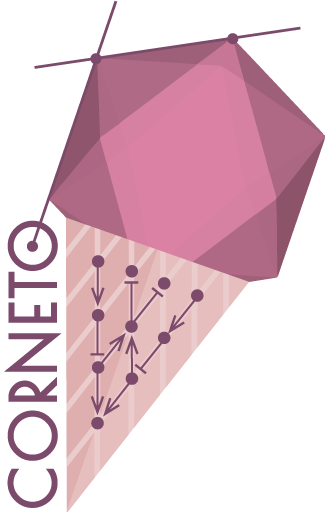

In [1]:
import cobra
import corneto as cn
import cvxpy as cp
import numpy as np
import cvxpy as cp
import pandas as pd
from cobra.io import load_model
from copy import deepcopy
import os 
import warnings
import contextlib

print(cobra.__version__, np.__version__)

cobra_cfg = cobra.Configuration()
cobra_cfg.solver = "glpk_exact"

cn.info()

In [2]:
solver = "GUROBI"
tol = 1e-6

In [3]:
# We load with COBRApy the MitoCore XML file with the prior knowledge network

with warnings.catch_warnings(), contextlib.redirect_stderr(None):
    warnings.simplefilter("ignore")
    model = cobra.io.read_sbml_model("mitocore_v1.01.xml")
    model.objective = "EX_biomass_e"

# Check the max biomass attainable
model.optimize()

,fluxes,reduced_costs
EX_2hb_e,0.000,0.0
EX_ac_e,0.000,0.0
EX_acac_e,-0.114,0.0
EX_akg_e,0.000,0.0
EX_ala_B_e,0.000,0.0
...,...,...
COt,0.000,0.0
NOt,0.000,0.0
PCHOLHSTDe,0.000,0.0
PSt3,0.000,0.0


In [4]:
# Load the cobra model as a corneto graph
G = cn.Graph.from_cobra_model(model)
G.shape

(441, 555)

In [5]:
#G.save("mitocore")

In [6]:
# First, we generate a subnetwork from mitcore as ground truth
rxn_obj_id = next(G.get_edges_by_attr("id", "EX_biomass_e"))

# For completion, we show the full FBA implementation
# from CORNETO. The implementation extends the Flow
# building block, making it easy to model and customize
# the method.

def corneto_fba(G, rxn_obj=None, min_flux=None, sparse=False):
    lb = np.array(G.get_attr_from_edges("default_lb"))
    ub = np.array(G.get_attr_from_edges("default_ub"))
    P = cn.opt.Flow(G, lb=lb, ub=ub, values=True, n_flows=1)
    F = P.expr.flow
    if sparse:
         # Add binary indicators for reactions (_flow_i by default)
        P += cn.opt.Indicator(F)
        # Minimize the number of active flows
        P.add_objectives(sum(P.expr._flow_i))
    if rxn_obj is not None:
        if isinstance(rxn_obj, str):
            rxn_obj = next(G.get_edges_by_attr("id", rxn_obj))
        if min_flux is not None:
            P += F[rxn_obj] >= min_flux
        P.add_objectives(-F[rxn_obj])
    return P

problem = corneto_fba(G, rxn_obj=rxn_obj_id, sparse=True, min_flux=100)
problem.solve(solver=solver, IntegralityFocus=1, verbosity=0)
opt_flux = problem.expr.flow[rxn_obj_id].value

rxns = G.get_attr_from_edges("id")

blocked = [rxns[i] for i, val in enumerate(problem.expr._flow_i.value == 0) if val]
len(blocked), sum(problem.expr._flow_i.value == 0)

Set parameter Username
Set parameter LicenseID to value 2593994
Academic license - for non-commercial use only - expires 2025-12-02


(468, 468)

In [7]:
# We block the reactions
for r in model.reactions:
    if r.id in blocked:
        r.lower_bound = 0
        r.upper_bound = 0
    # Constrain the space of feasible
    # fluxes to those that generate
    # at least some biomass
    if r.id == "EX_biomass_e":
        r.lower_bound = 0

model.optimize()

,fluxes,reduced_costs
EX_2hb_e,0.0,0.0
EX_ac_e,0.0,0.0
EX_acac_e,0.0,0.0
EX_akg_e,0.0,0.0
EX_ala_B_e,0.0,0.0
...,...,...
COt,0.0,0.0
NOt,0.0,0.0
PCHOLHSTDe,0.0,0.0
PSt3,0.0,0.0


In [8]:
from cobra.sampling import OptGPSampler

# Now we sample fluxes from the reduced model. This
# generates the dataset that we will use
# for evaluating the performance. To do this,
# we use the OptGP sampler method from cobrapy

sampler = OptGPSampler(model, thinning = 1000)
df_samples = sampler.sample(1000)
df_samples

,EX_2hb_e,EX_ac_e,EX_acac_e,EX_akg_e,EX_ala_B_e,EX_ala_L_e,EX_arg_L_e,EX_argsuc_e,EX_asn_L_e,EX_asp_L_e,...,FOLt_MitoCore,NADHt_MitoCore,NADt_MitoCore,NADHtm_MitoCore,NADtm_MitoCore,COt,NOt,PCHOLHSTDe,PSt3,PEt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_samples.std(axis=0).sort_values(ascending=False).head(20)

H2Otm               27.988435
ATPtmB_MitoCore     25.035445
PIt2mB_MitoCore     25.035445
Biomass_MitoCore    24.676648
OF_ATP_MitoCore     24.676648
EX_biomass_e        24.676648
CV_MitoCore         23.281586
CIII_MitoCore       10.089634
CI_MitoCore          6.878828
O2tm                 5.051680
EX_o2_e              5.051680
O2t                  5.051680
CIV_MitoCore         5.044817
CO2t                 3.600440
EX_co2_e             3.600440
CO2tm                3.600440
EX_h2o_e             3.202195
H2Ot                 3.202195
MDHm                 1.877983
ACONTm               1.754475
dtype: float64

<Axes: >

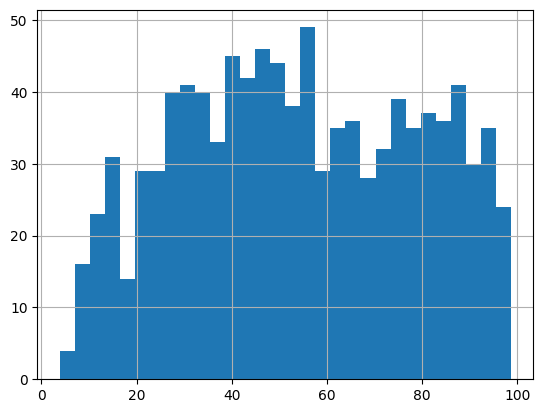

In [10]:
# Let's check the distribution of feasible biomasses from this reduced model
df_samples.loc[:, "EX_biomass_e"].hist(bins=30)

In [11]:
# We only select a small number of samples for our ground truth
# to make the experiment more challenging and realistic

df_subset_fluxes = df_samples.sample(frac=0.01)
df_data = df_subset_fluxes
df_data

,EX_2hb_e,EX_ac_e,EX_acac_e,EX_akg_e,EX_ala_B_e,EX_ala_L_e,EX_arg_L_e,EX_argsuc_e,EX_asn_L_e,EX_asp_L_e,...,FOLt_MitoCore,NADHt_MitoCore,NADt_MitoCore,NADHtm_MitoCore,NADtm_MitoCore,COt,NOt,PCHOLHSTDe,PSt3,PEt
684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Save the sampled fluxes
df_data.to_csv("flux_sample.csv")

In [13]:
# This method is used to hide a given fraction of the
# fluxes (across all samples), to use the rest as
# training to fit and measure the performance

def data_split(df, test_fraction=0.2, random_state=None):
    if not 0 <= test_fraction <= 1:
        raise ValueError("test_fraction must be between 0 and 1.")

    n_rows, n_cols = df.shape

    # Initialize a random number generator.
    rs = np.random.RandomState(random_state)

    # Determine the number of test entries per row.
    # We use rounding so that every row gets approximately the same fraction.
    n_test = int(round(n_cols * test_fraction))
    
    # Ensure that if test_fraction > 0 each row has at least one test entry.
    if test_fraction > 0 and n_test == 0:
        n_test = 1
    # Similarly, if test_fraction < 1, leave at least one entry in training.
    if test_fraction < 1 and n_test >= n_cols:
        n_test = n_cols - 1

    # Build a boolean mask of shape (n_rows, n_cols) indicating test entries.
    test_mask = np.zeros((n_rows, n_cols), dtype=bool)
    for i in range(n_rows):
        # Randomly select columns for test in the i-th row.
        test_cols = rs.choice(n_cols, size=n_test, replace=False)
        test_mask[i, test_cols] = True

    # Create the training and test DataFrames.
    df_train = df.mask(test_mask)
    df_test = df.where(test_mask)

    # Extract the test entries (row, col, value).
    test_row_idx, test_col_idx = np.where(test_mask)
    test_values = df.to_numpy()[test_row_idx, test_col_idx]
    test_entries = pd.DataFrame({
        'row': df.index[test_row_idx],
        'col': df.columns[test_col_idx],
        'value': test_values
    })

    # Extract the training entries.
    train_row_idx, train_col_idx = np.where(~test_mask)
    train_values = df.to_numpy()[train_row_idx, train_col_idx]
    train_entries = pd.DataFrame({
        'row': df.index[train_row_idx],
        'col': df.columns[train_col_idx],
        'value': train_values
    })

    return df_train, df_test, train_entries, test_entries


In [14]:
# Check if works well
df_train, df_test, _, _ = data_split(df_data, test_fraction=0.2)

df_train.isna().mean(axis=1), df_test.isna().mean(axis=1)

(684    0.2
 627    0.2
 343    0.2
 809    0.2
 443    0.2
 750    0.2
 829    0.2
 106    0.2
 15     0.2
 207    0.2
 dtype: float64,
 684    0.8
 627    0.8
 343    0.8
 809    0.8
 443    0.8
 750    0.8
 829    0.8
 106    0.8
 15     0.8
 207    0.8
 dtype: float64)

In [27]:
df_train.to_csv("flux_train.csv")
df_test.to_csv("flux_test.csv")

## Method implementation and test

We show here how the multi-condition regularized flux fitting method is implemented in CORNETO. We show also how to run the validation. The full script for job submitting and validation is in `run_experiments_slurm.py` file.

In [15]:
test_frac = 0.80
l2_reg = 1e-3
lambd = 0
noise = 1.0

df_train, df_test, _, _ = data_split(df_data, test_fraction=test_frac, random_state=42)
df_train = df_train + np.random.normal(scale=noise, size=df_train.shape)

# The flux fitting method is easy to implement using the Flow building block
def corneto_multi_fba(G, nflows=1):
    lb = np.array(G.get_attr_from_edges("default_lb"))
    ub = np.array(G.get_attr_from_edges("default_ub"))
    P = cn.opt.Flow(G, lb=lb, ub=ub, values=True, n_flows=nflows)
    return P

def create_flux_fitting_problem(G, df_train, lambd=lambd, l2_reg=l2_reg):
    # Base problem
    P = corneto_multi_fba(G, nflows=df_train.shape[0])
    
    # Adding the objective functions:
    # - For each sample (row), we add an obj. to fit fluxes (independently)
    # with L2 regularization
    
    for i in range(df_train.shape[0]):
        y = df_train.iloc[i, :].values
        idx = np.flatnonzero(~np.isnan(y))
        print(f"Training data for sample {i}: {len(idx)}")
        P.add_objectives((P.expr.flow[idx, i] - y[idx]).norm(p=2).sum())
        P.add_objectives(P.expr.flow[:,i].norm(p=2), weights=l2_reg)

    # Finally, we add the structured sparsity penalty for joint inference
    P += cn.opt.Indicator(P.expr.flow)
    P += cn.opt.linear_or(P.expr._flow_i, axis=1, varname="Y")
    P.add_objectives(sum(P.expr.Y), weights=lambd)
    return P
    
P = create_flux_fitting_problem(G, df_train)
P.solve(solver="GUROBI", MIPFocus=1, Heuristics=0.20, verbosity=1, MIPGap=0.01, TimeLimit=300)

# Compute errors
df_pred = pd.DataFrame(P.expr.flow.value, index=df_train.columns, columns=df_train.index).T

for o in P.objectives:
    print(o.value)
    

Training data for sample 0: 111
Training data for sample 1: 111
Training data for sample 2: 111
Training data for sample 3: 111
Training data for sample 4: 111
Training data for sample 5: 111
Training data for sample 6: 111
Training data for sample 7: 111
Training data for sample 8: 111
Training data for sample 9: 111
                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Apr 26 01:36:16 PM: Your problem has 11655 variables, 30920 constraints, and 0 parameters.
(CVXPY) Apr 26 01:36:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 26 01:36:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 26 01:36:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 26 01:36:16 PM: Your problem is compiled with the CPP canonicaliz

In [16]:
# As a simple baseline, we can use mean imputation
# NOTE: We're interested in the performance of the multi-condition alone,
# but having a simple baseline can give some reference to see if the method
# works as expected.

def impute_mean(df):
    baseline_pred = np.empty_like(df, dtype=float)
    for j, col in enumerate(df.columns):
        # Compute the mean while ignoring NaNs
        col_mean = df[col].mean(skipna=True)
        if pd.isna(col_mean):
            col_mean = 0.0
        # Use the computed mean for every row in that column for the prediction
        baseline_pred[:, j] = col_mean
    return baseline_pred

In [17]:
# Error metrics

df_diff = df_test - df_pred
rmse = np.sqrt(np.mean(df_diff**2))

# Baseline (mean imputation)
rmse_impute = np.sqrt(np.mean((df_test - impute_mean(df_train))**2))

print(f"RMSE: {rmse:.4f}, (mean impute RMSE: {rmse_impute:.4f})")

RMSE: 3.8068, (mean impute RMSE: 4.1051)


In [18]:
df_test

,EX_2hb_e,EX_ac_e,EX_acac_e,EX_akg_e,EX_ala_B_e,EX_ala_L_e,EX_arg_L_e,EX_argsuc_e,EX_asn_L_e,EX_asp_L_e,...,FOLt_MitoCore,NADHt_MitoCore,NADt_MitoCore,NADHtm_MitoCore,NADtm_MitoCore,COt,NOt,PCHOLHSTDe,PSt3,PEt
684,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0
627,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0
343,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
809,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
443,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
750,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN
829,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
106,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
15,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0


<Axes: xlabel='true', ylabel='pred'>

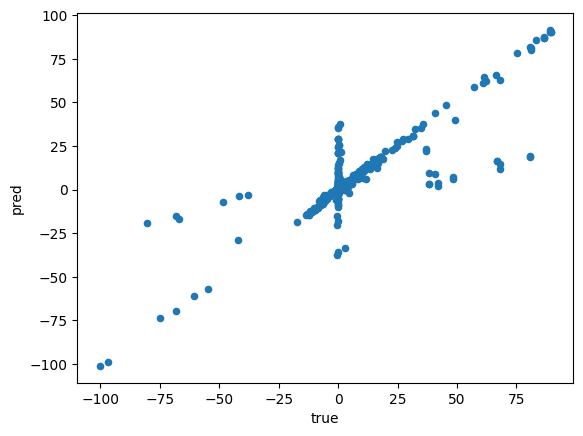

In [19]:
df_x = df_test.stack(future_stack=True)
df_y = df_pred.stack()
y = df_y[~df_x.isna()]
x = df_x.dropna()
df_test_pred = pd.concat([x, y], axis=1)
df_test_pred.columns = ["true", "pred"]
df_test_pred.plot.scatter(x="true", y="pred")

In [23]:
P = create_flux_fitting_problem(G, df_train, lambd=1.0)
P.solve(solver="GUROBI", MIPFocus=1, Heuristics=0.20, verbosity=1, MIPGap=0.01, TimeLimit=120)

Training data for sample 0: 111
Training data for sample 1: 111
Training data for sample 2: 111
Training data for sample 3: 111
Training data for sample 4: 111
Training data for sample 5: 111
Training data for sample 6: 111
Training data for sample 7: 111
Training data for sample 8: 111
Training data for sample 9: 111
                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Apr 26 01:47:11 PM: Your problem has 11655 variables, 30920 constraints, and 0 parameters.
(CVXPY) Apr 26 01:47:11 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 26 01:47:11 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 26 01:47:11 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 26 01:47:11 PM: Your problem is compiled with the CPP canonicaliz

/Users/pablorodriguezmier/miniforge3/envs/corneto-fork/lib/python3.12/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Problem(Minimize(Expression(CONVEX, NONNEGATIVE, ())), [Inequality(Constant(CONSTANT, NONPOSITIVE, (555, 10))), Inequality(Variable((555, 10), _flow)), Equality(Expression(AFFINE, UNKNOWN, (441, 10)), Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, NONNEGATIVE, (160, 10)), Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, UNKNOWN, (160, 10)), Constant(CONSTANT, ZERO, ())), Inequality(Expression(AFFINE, NONPOSITIVE, (555, 10))), Inequality(Variable((555, 10), _flow)), Inequality(Expression(AFFINE, NONNEGATIVE, (555,))), Inequality(Variable((555,), Y, boolean=True))])

<Axes: xlabel='true', ylabel='pred'>

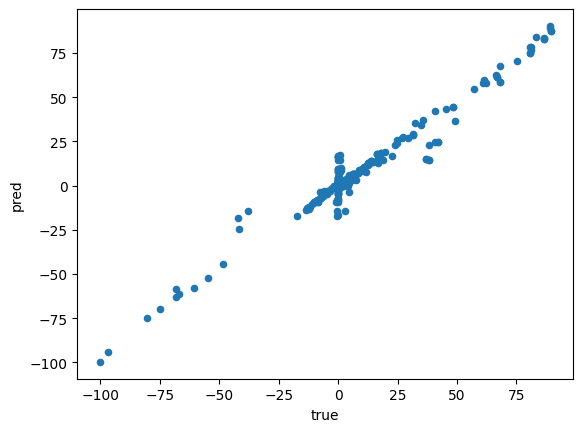

In [24]:
df_pred_reg = pd.DataFrame(P.expr.flow.value, index=df_train.columns, columns=df_train.index).T
df_x = df_test.stack(future_stack=True)
df_y = df_pred_reg.stack()
y = df_y[~df_x.isna()]
x = df_x.dropna()
df_test_pred_reg = pd.concat([x, y], axis=1)
df_test_pred_reg.columns = ["true", "pred"]
df_test_pred_reg.plot.scatter(x="true", y="pred")

In [25]:
df_diff = df_test - df_pred_reg
rmse = np.sqrt(np.mean(df_diff**2))
rmse

1.5394774648699523

Text(421.50000000000006, 0.5, 'predicted flux')

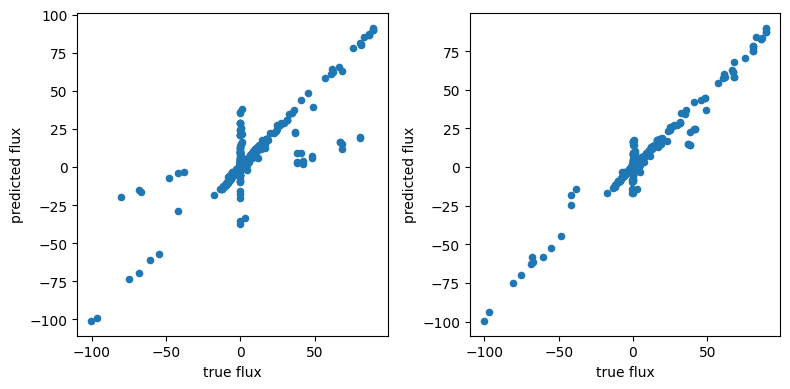

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
df_test_pred.plot.scatter(x="true", y="pred", ax=ax[0])
df_test_pred_reg.plot.scatter(x="true", y="pred", ax=ax[1])
ax[0].set_xlabel("true flux")
ax[0].set_ylabel("predicted flux")
plt.tight_layout()
plt.savefig(f"compare_lam0_lam1_test_frac_{test_frac}_noise_{noise}.pdf")
ax[1].set_xlabel("true flux")
ax[1].set_ylabel("predicted flux")

In [40]:
df_test_pred.to_csv("prediction_lam0.csv")
df_test_pred_reg.to_csv("prediction_lam1.csv")